In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import GraphRenderer, Circle, MultiLine
from bokeh.palettes import Spectral4

# Create a graph using the networkx library

import random
import pickle
import time

import pandas as pd

colormap = {
    1:"blue",2:"red",3:"green",4:"orange",5:"purple",6:"brown",7:"pink",8:"gray",9:"olive",10:"cyan",11:"black",
    12:"yellow",13:"lightcoral",14:"maroon",15:"sienna",16:"peru",17:"tan",18:"gold",19:"darkkhaki",20:"olive",
    21:"lime",22:"turquoise",23:"teal",24:"midnightblue",25:"darkviolet",26:"fuchsia"
}

def sort_by_func(lst, func):
    tuples = [(val, func(val)) for val in lst]
    # Sort the tuples based on the second element (i.e. the function output).
    sorted_tuples = sorted(tuples, key=lambda tup: tup[1])
    # Return a new list containing the first element of each tuple (i.e. the original values) in the sorted order.
    return [tup[0] for tup in sorted_tuples]

def firstFit(graph, colormap):
    og_nodes = graph.nodes()
    #nodes = sort_by_func(og_nodes, graph.degree)
    nodes = list(og_nodes)
    nG = nx.Graph()
    all_colors = [i for i in range(1,27)]
    gc_map = [-1 for i in range(0,len(nodes))]
    #print(gc_map)
    added_nodes = []
    vert = nodes.pop(0)
    nG.add_node(vert)
    added_nodes.append(vert)
    
    node_color = {vert: colormap[1]}  # Node 3 will be red
    nx.set_node_attributes(nG, node_color, 'color')
    gc_map[vert]= 1
    
    while(len(nodes)>0):
        vert = nodes.pop(0)
        edgeso = nG.edges()
#         for e in edgeso:
#             print(e)
#         print("Processing vertex "+str(vert))
        vert_edges = graph.edges(vert)
        n_edges =[]
        non_adjacent_colors = all_colors.copy() 
#         print(non_adjacent_colors)
        for edge in vert_edges:
            source, end = edge
            if end in added_nodes:
                n_edges.append(edge)
#                 print(gc_map[end])
                if gc_map[end] in non_adjacent_colors:
                    non_adjacent_colors.remove(gc_map[end])
        vcolor = min(non_adjacent_colors)
        node_color = {vert: colormap[vcolor]}
        nG.add_node(vert)
        nx.set_node_attributes(nG, node_color, 'color')
        gc_map[vert]=vcolor
        for edge in n_edges:
            start, end = edge
            nG.add_edge(start, end)
        added_nodes.append(vert)
        #print nG graph here - to show the progress vertex by vertex
#         print("----------------------------")
    return nG, gc_map 
	
	

def generate_map(n,p):
    # create an empty graph
    G = nx.Graph()

    # add nodes to the graph
    for i in range(n):
        G.add_node(i)

    # add edges to the graph
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p and not G.has_edge(i, j):
                # add the edge if the probability is met and it doesn't create a triangle
                common_neighbors = set(G.neighbors(i)).intersection(set(G.neighbors(j)))
                if len(common_neighbors) == 0:
                    G.add_edge(i, j)
    return G
	


def save_graph(G, gid):
    with open('Graph_'+str(gid), 'wb') as f:
        pickle.dump(G, f)
    return 'Graph_'+str(gid)
	
	
def load_graph(pfile):
    with open(pfile, 'rb') as f:
        G = pickle.load(f)
    gid = pfile.split('_')[1].split(".")[0]
    return G, gid
	

def plot_normal(G, gid):
    pos = nx.circular_layout(G)
#     fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_edges(G, pos, width=1)
    nx.draw_networkx_labels(G, pos, font_size=10,  font_family="sans-serif")
    
#     plt.axis("off")
#     plt.show()
    plt.savefig('Initial_'+str(gid)+'.png', dpi=300, bbox_inches='tight')
    plt.clf()
	

def plot_colored(G, gid):
    
    nG, gc_map = firstFit(G, colormap)
    pos = nx.circular_layout(nG)
    nx.draw_networkx_nodes(nG, pos, node_size=500)
    nx.draw_networkx_edges(nG, pos, width=1)
    
    #colors = ["r" if color_map[v] == 0 else "b" for v in G]
#     print(gc_map)
    ncolors = [colormap[gc_map[i]] for i in nG.nodes()]

    nx.draw(nG, pos=nx.circular_layout(nG), node_color=ncolors)
    #nx.draw_networkx_labels(nG, pos, font_size=20, font_family="sans-serif")
#     plt.axis("off")
#     plt.show()
    plt.savefig('Colored_'+str(gid)+'.png', dpi=300, bbox_inches='tight')
    return nG, gc_map
    plt.clf()
	

def run_experiment():
    df = pd.read_excel('FirstFitStats.xlsx')
    gid = 4000
    for i in range(100,101):
        p=0.25
        n = i
        while p <= 0.40:
            for j in tqdm(range(0,25)):
                G = generate_map(n,p)
                gid = int(gid)
                gid+=1
                filepath = save_graph(G, gid)
                time.sleep(1)
                G, gid = load_graph(filepath)
                plot_normal(G, gid)
                nG, gc_map = plot_colored(G, gid)
                colorset = set(gc_map)
                colorCount = len(colorset)
                new_row = { 'Graph Id':filepath, 'vertex_count':n, 'color_count':colorCount }
                df.loc[len(df)] = new_row
            p+=0.05

    df.to_excel('FirstFitStats.xlsx', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:45<00:00,  1.84s/it]


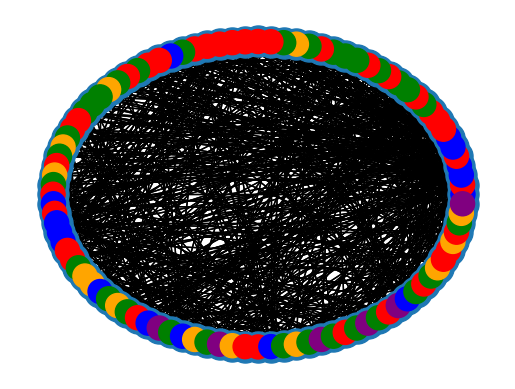

In [2]:
run_experiment()